/Users/limengfeiyang/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


=== Decision Tree Classifier ===
Accuracy: 0.7782

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1291
           1       0.60      0.50      0.55       467

    accuracy                           0.78      1758
   macro avg       0.71      0.69      0.70      1758
weighted avg       0.77      0.78      0.77      1758

Confusion Matrix:
 [[1133  158]
 [ 232  235]]


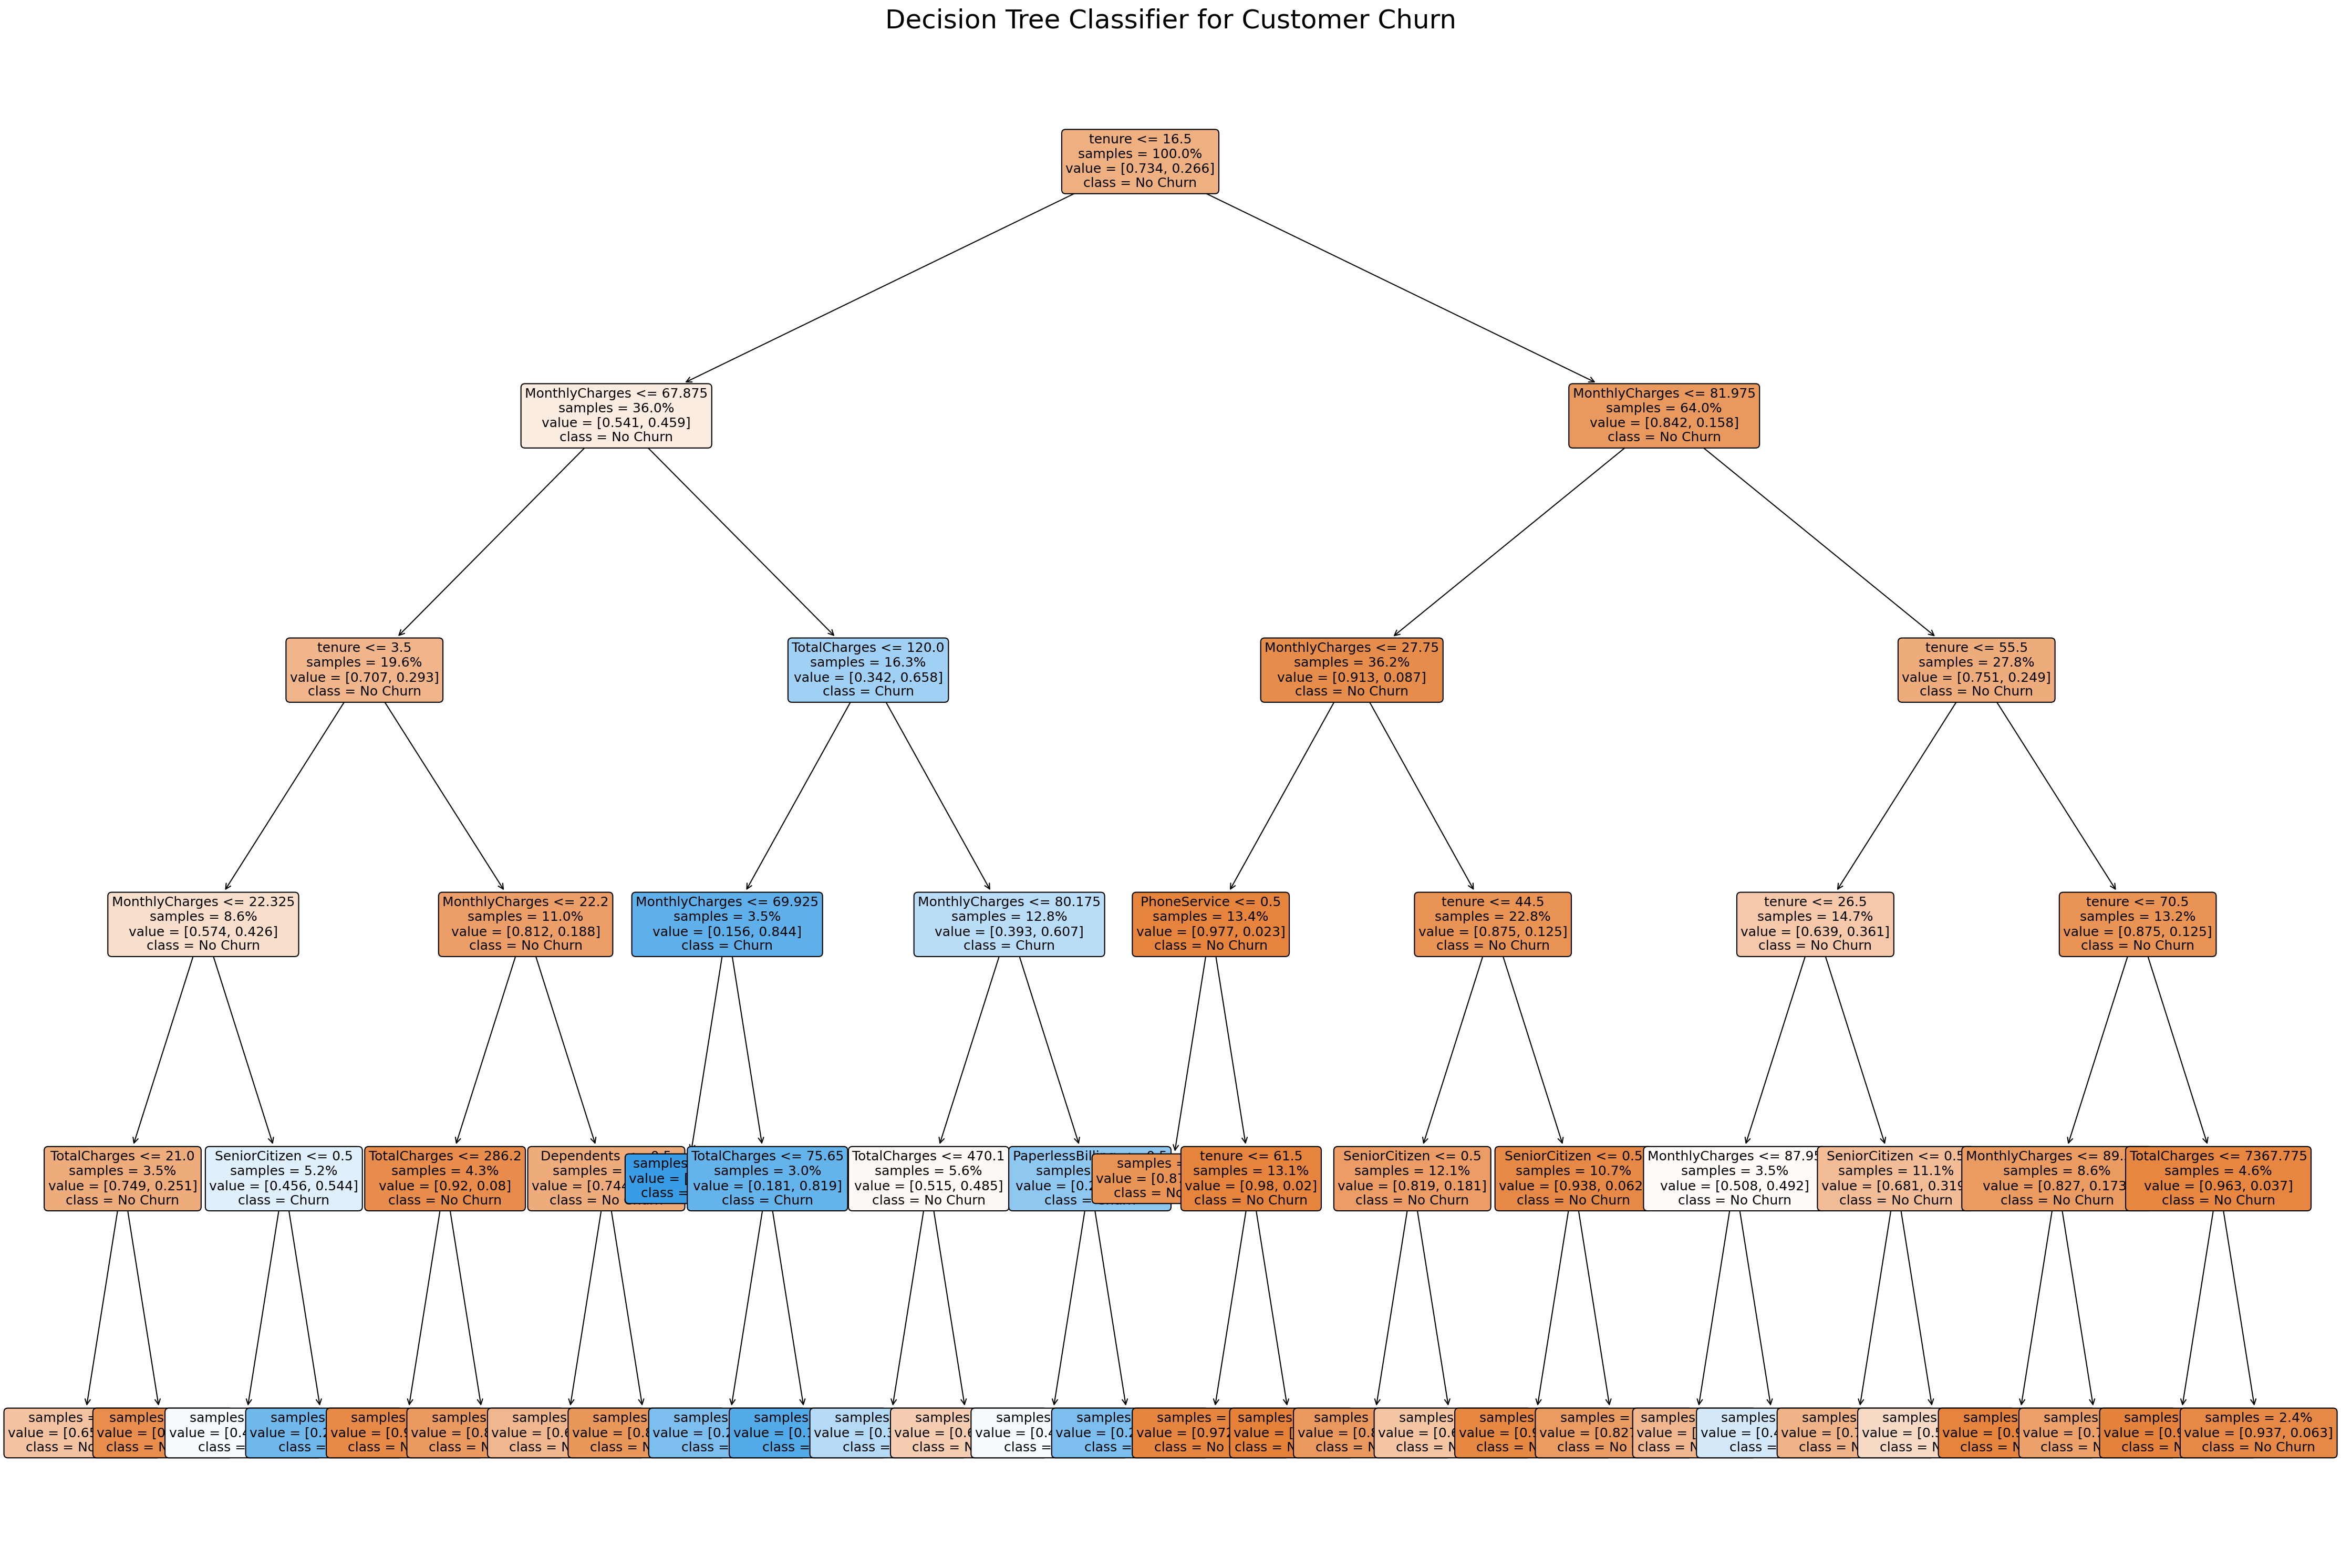

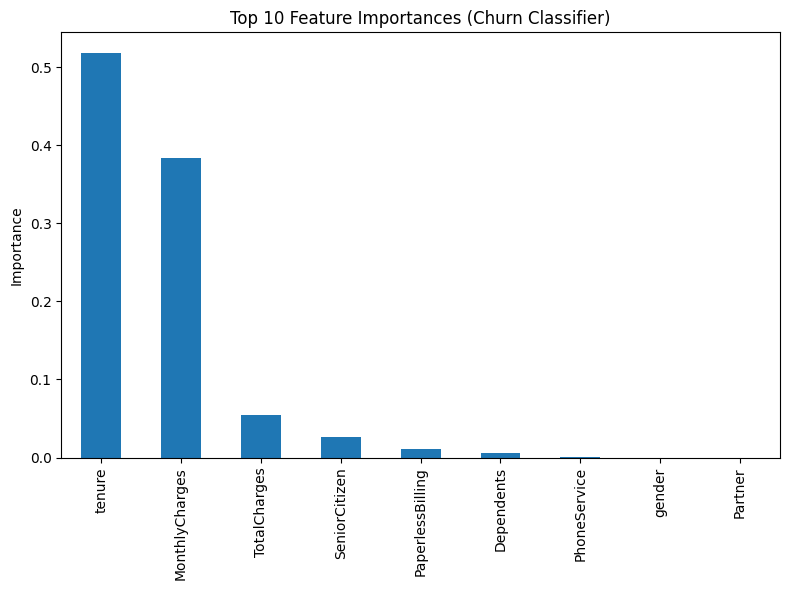


=== Decision Tree Regressor ===
MSE: 0.64
R² : 0.9993


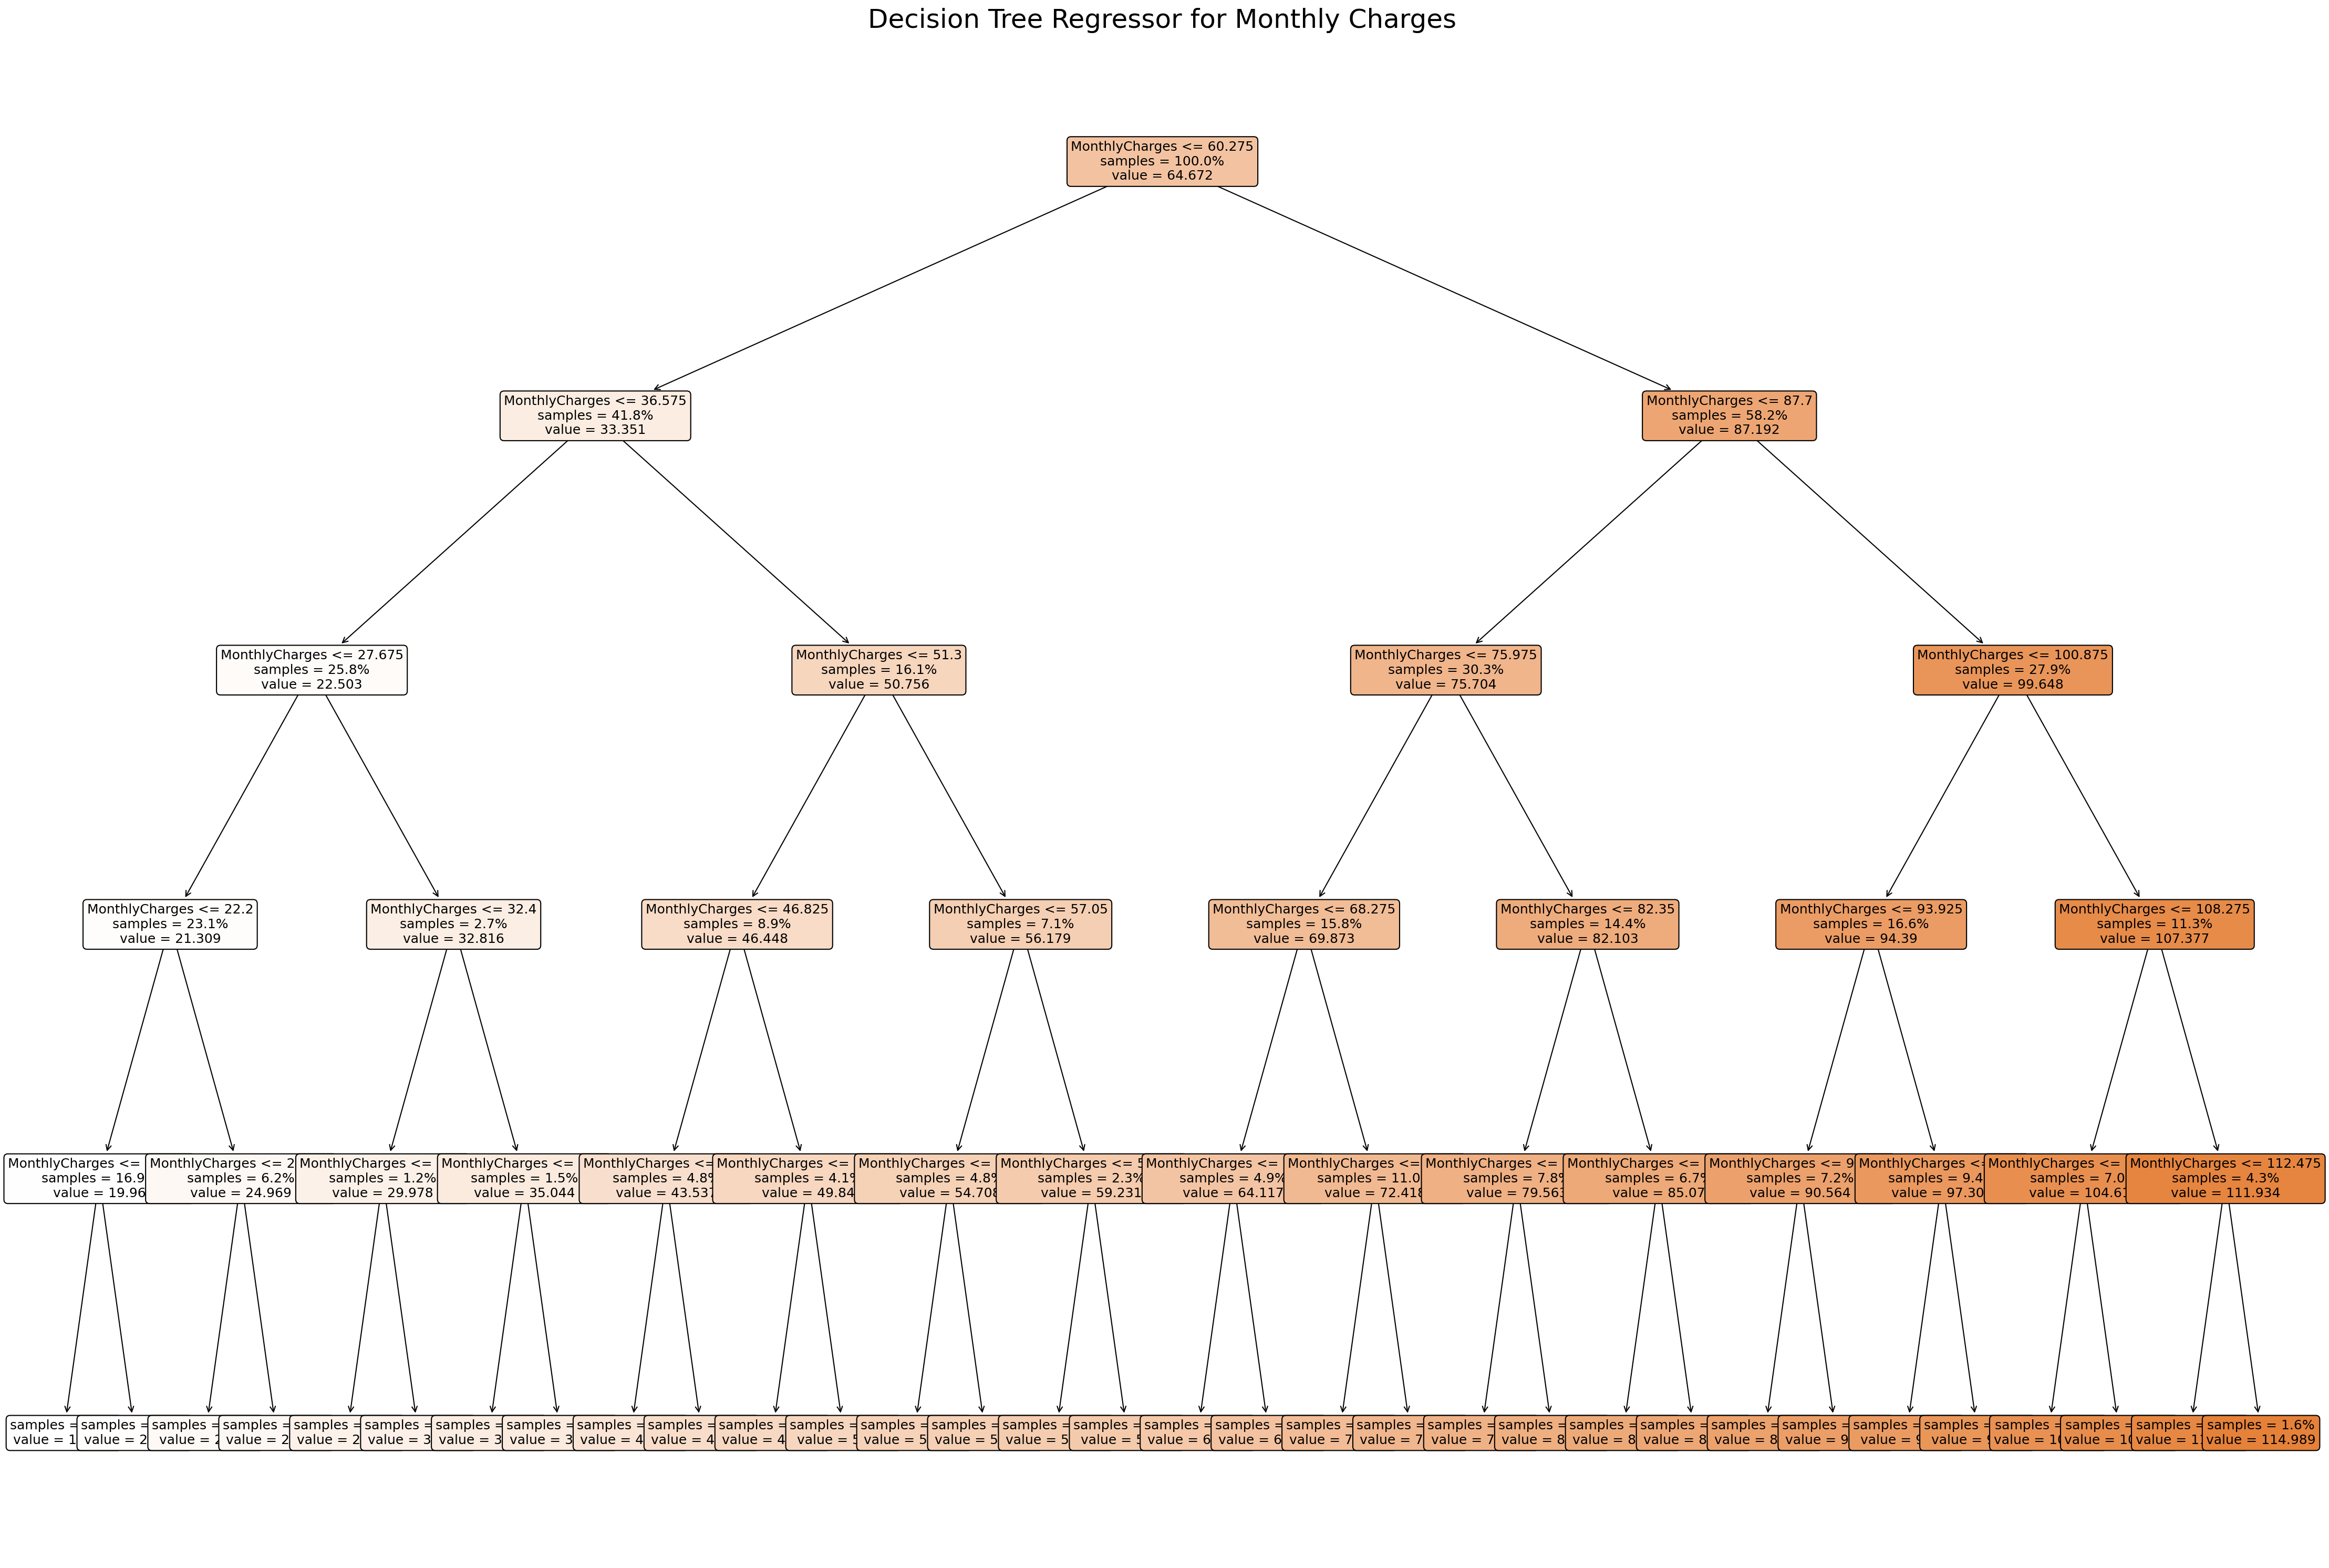

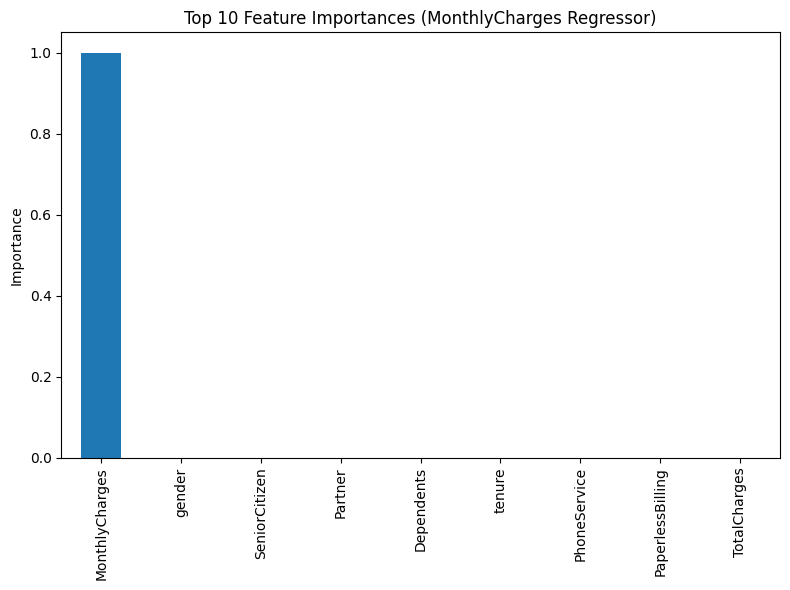

In [9]:
#!/usr/bin/env python3

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score,
)

# Load CSV data and drop missing values
def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv('/Users/limengfeiyang/CMOR438-final-project/data/telco_churn_clean.csv')
    df = df.dropna()
    return df


# Encode categorical features, assemble feature matrix X,
# and define targets for classification and regression.

def preprocess(df: pd.DataFrame):
    # Ensure Churn is integer 0/1
    df['Churn'] = df['Churn'].astype(int)

    # Identify columns
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    num_cols = df.select_dtypes(include=['int64', 'float64']).drop('Churn', axis=1).columns.tolist()

    # One-hot encode categorical variables, drop first to avoid dummy trap
    ohe = OneHotEncoder(sparse=False, drop='first')
    X_cat = ohe.fit_transform(df[cat_cols])

    # Numeric features array
    X_num = df[num_cols].values

    # Combine numeric and categorical
    X = np.hstack([X_num, X_cat])

    # Targets
    y_class = df['Churn'].values
    y_reg   = df['MonthlyCharges'].values

    # Feature names for plotting
    feature_names = num_cols + list(ohe.get_feature_names_out(cat_cols))

    return X, y_class, y_reg, feature_names


# Split into train/test for both classification and regression
def split_data(X, y_class, y_reg, test_size=0.25, random_state=42):
    
    Xc_train, Xc_test, yc_train, yc_test = train_test_split(
        X, y_class, test_size=test_size, stratify=y_class, random_state=random_state
    )
    Xr_train, Xr_test, yr_train, yr_test = train_test_split(
        X, y_reg, test_size=test_size, random_state=random_state
    )
    return (Xc_train, Xc_test, yc_train, yc_test), (Xr_train, Xr_test, yr_train, yr_test)


# Train Decision Tree Classifier
def train_classifier(X_train, y_train, max_depth=5, min_samples_leaf=10, random_state=42):
    clf = DecisionTreeClassifier(
        criterion='gini',
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    clf.fit(X_train, y_train)
    return clf


# Evaluate classifier: accuracy, report, confusion matrix
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    acc    = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm     = confusion_matrix(y_test, y_pred)
    return acc, report, cm


def train_regressor(X_train, y_train,
                    max_depth=5, min_samples_leaf=10, random_state=42):
    regr = DecisionTreeRegressor(
        criterion='squared_error',
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    regr.fit(X_train, y_train)
    return regr


# Evaluate regressor: MSE and R^2
def evaluate_regressor(regr, X_test, y_test):
    y_pred = regr.predict(X_test)
    mse    = mean_squared_error(y_test, y_pred)
    r2     = r2_score(y_test, y_pred)
    return mse, r2


# Plot a decision tree with large figure, high DPI, big font, and depth limit.
# - max_plot_depth: int or None, how many levels to draw (None = full tree)
def plot_readable_tree(model, feature_names, class_names=None, title="", filename=None,
                       max_plot_depth=None):

    plt.figure(figsize=(30, 20), dpi=150)
    plot_tree(
        model,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=12,
        max_depth=max_plot_depth,
        impurity=False,
        proportion=True,
        label='all'
    )
    plt.title(title, fontsize=24)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()


# Plot bar chart of top N feature importances
def plot_feature_importance(importances, feature_names, top_n=10, title="", filename=None):
    imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top_imp    = imp_series.head(top_n)
    plt.figure(figsize=(8,6), dpi=100)
    top_imp.plot(kind='bar')
    plt.ylabel("Importance")
    plt.title(title)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()


def main():
    data_path = '/Users/limengfeiyang/CMOR438-final-project/data/telco_churn_clean.csv'

    # Load & preprocess
    df = load_data(data_path)
    X, y_class, y_reg, feature_names = preprocess(df)

    # Split
    (Xc_train, Xc_test, yc_train, yc_test), \
    (Xr_train, Xr_test, yr_train, yr_test) = split_data(X, y_class, y_reg)

    # Train & evaluate classifier
    clf = train_classifier(Xc_train, yc_train)
    acc, report, cm = evaluate_classifier(clf, Xc_test, yc_test)
    print("=== Decision Tree Classifier ===")
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    # Visualize classifier tree & feature importances
    plot_readable_tree(
        clf,
        feature_names,
        class_names=['No Churn','Churn'],
        title="Decision Tree Classifier for Customer Churn",
        filename="churn_tree_readable.png",
        max_plot_depth=None
    )
    plot_feature_importance(
        clf.feature_importances_,
        feature_names,
        top_n=10,
        title="Top 10 Feature Importances (Churn Classifier)",
        filename="churn_feature_importance.png"
    )

    # Train & evaluate regressor
    regr = train_regressor(Xr_train, yr_train)
    mse, r2  = evaluate_regressor(regr, Xr_test, yr_test)
    print("\n=== Decision Tree Regressor ===")
    print(f"MSE: {mse:.2f}")
    print(f"R² : {r2:.4f}")

    # Visualize regressor tree & feature importances
    plot_readable_tree(
        regr,
        feature_names,
        title="Decision Tree Regressor for Monthly Charges",
        filename="charges_tree_readable.png",
        max_plot_depth=None
    )
    plot_feature_importance(
        regr.feature_importances_,
        feature_names,
        top_n=10,
        title="Top 10 Feature Importances (MonthlyCharges Regressor)",
        filename="charges_feature_importance.png"
    )

if __name__ == "__main__":
    main()
